In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from mrcnn.config import Config
#import utils
from mrcnn import model as modellib
from mrcnn.mrcnn import utils
from mrcnn import visualize
import yaml
from mrcnn.model import log
from PIL import Image

Using TensorFlow backend.


In [2]:
ROOT_DIR = os.path.abspath("")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)
iter_num=0

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


C:\Users\VCC\Desktop\Mask_RCNN\logs


In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shape"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 6 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50


config = ShapesConfig()
# config.display()


In [4]:
class DrugDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image,image_id):
        #print("draw_mask-->",image_id)
        #print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        #print("info-->",info)
        #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    #print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    # 重新写load_shapes，里面包含自己的类别,可以任意添加
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes,可通过这种方式扩展多个物体
        self.add_class("shapes", 1, "head")
        self.add_class("shapes", 2, "quilt")
        self.add_class("shapes", 3, "corner")
        self.add_class("shapes", 4, "edge")
        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            #print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            #print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
            #filestr = filestr.split("_")[1]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "labelme_json/rgb_" + filestr + "_json/info.yaml"
            # print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            cv_img = cv2.imread(dataset_root_path + "pic/" + filestr + ".png")

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        print("image_id",image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion

            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("edge") != -1:
                labels_form.append("edge")
            elif labels[i].find("quilt") != -1:
                labels_form.append("quilt")
            elif labels[i].find("corner") != -1:
                labels_form.append("corner")
            elif labels[i].find("head") != -1:
                labels_form.append("head")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)


In [5]:
dataset_root_path=ROOT_DIR+"/new_data/"
img_floder = dataset_root_path + "pic"
# print(img_floder)
mask_floder = dataset_root_path + "cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)
print(imglist)
print(count)

#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(count, img_floder, mask_floder, imglist, dataset_root_path)
dataset_train.prepare()
dataset_val = DrugDataset()
dataset_val.load_shapes(10, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val.prepare()
print("dataset_val-->",dataset_val._image_ids)

['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png', '180.png', '181.png'

dataset_val--> [0 1 2 3 4 5 6 7 8 9]


image_id 155


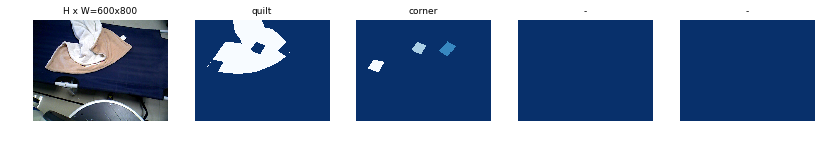

image_id 81


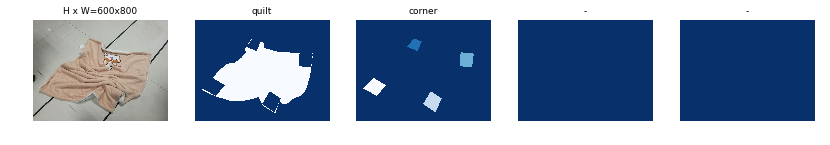

image_id 92


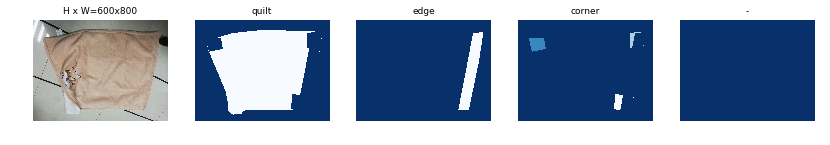

image_id 150


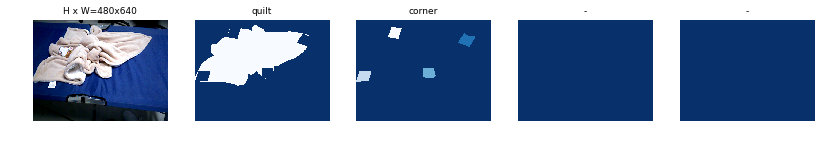

In [6]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id 5


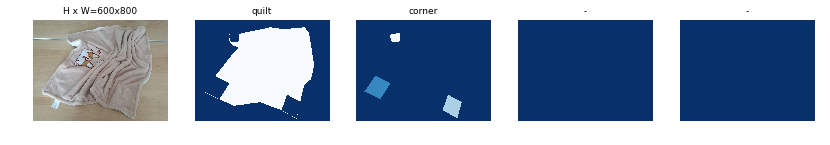

image_id 9


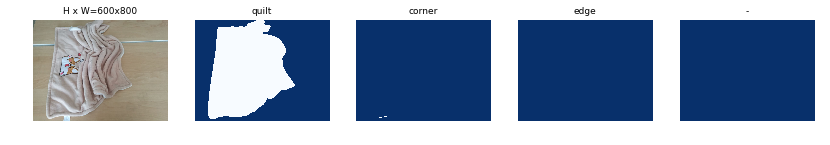

image_id 3


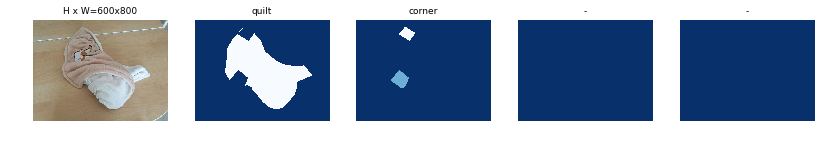

image_id 8


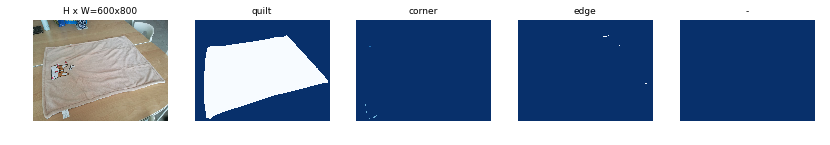

In [7]:

image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
   image = dataset_train.load_image(image_id)
   mask, class_ids = dataset_train.load_mask(image_id)
   visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [25]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [15]:
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=150,
            layers='all')

In [17]:
class Detect_Config(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
detectconfig=Detect_Config()
model = modellib.MaskRCNN(mode="inference", config=detectconfig,
                          model_dir=MODEL_DIR)
SHARP_MODEL_DIR=os.path.join(MODEL_DIR,"shapes20181018T0924")
SHARP_MODEL_PATH=os.path.join(SHARP_MODEL_DIR,"mask_rcnn_shapes_0000.h5")
SHARP_MODEL_PATH="C:/Users/VCC/Desktop/mask_rcnn_shape_0030.h5"
model.load_weights(SHARP_MODEL_PATH, by_name=True)
print(SHARP_MODEL_PATH)


C:/Users/VCC/Desktop/mask_rcnn_shape_0030.h5


In [3]:
import skimage
Quilt_DIR=os.path.join(ROOT_DIR,"quilt_data")
IMAGE_DIR=os.path.join(Quilt_DIR,"pic")
image = skimage.io.imread(os.path.join(IMAGE_DIR, "17.png"))
# image = skimage.io.imread("C:/Users/VCC/Desktop/3.jpg")

# Run detection
results = model.detect([image], verbose=1)
# print(image)
# Visualize results
r = results[0]
count=0
mask=np.zeros((r['masks'].shape[0],r['masks'].shape[1]))
print(r['masks'].shape)
for i in range(r['masks'].shape[0]):
    for j in range(r['masks'].shape[1]):
        if r['masks'][i][j][0]:
            count+=1
            mask[i][j]+=1
print(count)
plt.imshow(mask,cmap='gray')
plt.imshow(visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores']))


NameError: name 'ROOT_DIR' is not defined

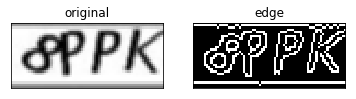

In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('C:/Users/VCC/Desktop/image.jpg',0)
img = cv2.GaussianBlur(img,(3,3),0)
edges = cv2.Canny(img,50,150)

plt.subplot(121),plt.imshow(img,cmap='gray')
plt.title('original'),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap='gray')
plt.title('edge'),plt.xticks([]),plt.yticks([])

plt.show()